# BARB API Demo: The advertising spots endpoint

In this demo of the advertising spots endpoint we will:

1. Gain access to the API by requesting an access token
2. Query the API, requesting audience sizes for all spots placed by DENTSU AEGIS LONDON on 10 November 2023
3. Reshape the data into a pandas dataframe
4. Use the data to work out which spots had the highest number of viewers among adults 16-34?

## Set up the python environment

In [1]:
import requests
import numpy as np
import json
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jupyterlab"

## Get the access token

This code uses your account details (substitute them in) to get an access token from the API

In [2]:
creds = {"email": "barb@thinkbluehat.com", "password": "Ajsvw&8KLE4k3vHg"}
token_request_url = "https://dev.barb-api.co.uk/api/v1/auth/token/"
response = requests.post(token_request_url, data = creds)
access_token = json.loads(response.text)['access']

## Get data from the API

The access token is then used to query the API.

In [3]:
head = {'Authorization': 'Bearer {}'.format(access_token)}
api_url = "https://dev.barb-api.co.uk/api/v1/advertising_spots/"

# The query parameters
params = {"min_transmission_date": "2022-11-10","max_transmission_date":"2022-11-10", "buyer_name": "DENTSU AEGIS LONDON"}
# MINDSHARE MEDIA UK L

# Query the API and turn the response into json
response = requests.get(url = api_url,headers=head, params=params)
api_data = json.loads(response.text)

How many spot events have been returned?

In [4]:
print("{} spot events".format(len(api_data["events"])))

5000 spot events


In [16]:
api_data['events'][43]

{'panel': {'panel_code': 50,
  'panel_region': 'BBC Network',
  'is_macro_region': False},
 'station': {'station_code': 4519,
  'station_name': 'NOW 70s',
  'split_transmission': False},
 'spot_type': 'Spot',
 'spot_start_datetime': {'barb_reporting_datetime': '2022-11-10 02:34:29',
  'barb_polling_datetime': '2022-11-10 02:34:29',
  'standard_datetime': '2022-11-10 02:34:29'},
 'spot_duration': 20,
 'preceding_programme_name': 'TELESHOPPING - SHOP DORMEO',
 'succeeding_programme_name': 'TELESHOPPING - SHOP DORMEO',
 'break_type': 'Centre Break',
 'broadcaster_spot_number': '928687410',
 'clearcast_information': {'commercial_number': 'TAGDGGB076020',
  'match_group_code': 0,
  'match_group_name': 'England, Scotland and Wales',
  'buyer_code': 'B000925',
  'buyer_name': 'MINDSHARE MEDIA UK L',
  'advertiser_code': 'A004642',
  'advertiser_name': 'UNILEVER UK HOME & P',
  'holding_company_code': 'H001102',
  'holding_company_name': 'UNILEVER',
  'product_code': 'P174542',
  'product_name

Note if there had been over 5000 events (the limit for a single API call) we would have needed to make several calls to the API using the `x_next` attribute.

## Reshape the data as a pandas dataframe

We now restructure the data as a pandas dataframe. The json data is highly flexible. We are choosing the parts of the data that we need and turning them into a table.

In [17]:
# Loop through the events and then the audiences within the events
spot_data = []
for e in api_data['events']:
    for v in e['audience_views']:
        spot_data.append({'panel_region': e['panel']['panel_region'],
                      'station_name': e['station']['station_name'],
                      'clearcast_commercial_title': e['clearcast_information']['clearcast_commercial_title'],
                                    'spot_start_datetime': e['spot_start_datetime']['standard_datetime'],
                                    'audience_code': v['audience_code'],
                                    'audience_size_hundreds': v['audience_size_hundreds']})
# Convert the result into a data frame
spot_data = pd.DataFrame(spot_data)

# Format the transmission_time_period as a pandas datetime
spot_data['spot_start_datetime'] = pd.to_datetime(spot_data['spot_start_datetime'])

# Add the audience category names. We have a temporary problem with duplicates in this data set hence the dropping of duplicates.
audience_categories_df = pd.DataFrame(api_data['audience_categories']).drop_duplicates(subset=['audience_code'])
spot_data = spot_data.merge(audience_categories_df, on = "audience_code").drop("audience_code", axis=1)
spot_data.head()

,panel_region,station_name,clearcast_commercial_title,spot_start_datetime,audience_size_hundreds,audience_name,audience_target_size_hundreds
0,BBC Network,DMAX,Persil GAIA 2022 What If,2022-11-10 01:45:23,73,All Homes,272300
1,BBC Network,Challenge TV,Persil GAIA 2022 What If,2022-11-10 04:38:47,133,All Homes,272300
2,BBC Network,BLAZE,DomestosBostonTVCenGB20,2022-11-10 00:13:43,161,All Homes,272300
3,BBC Network,5USA+1,HellmannsNomadVeganTVCenGB20,2022-11-10 03:12:53,28,All Homes,272300
4,BBC Network,Talking Pictures,Persil GAIA 2022 What If,2022-11-10 04:10:16,0,All Homes,272300


## Inspect the data

Checking what is in the data by looking at the average audience size for each audience category and panel.

In [18]:
spot_data.groupby(["clearcast_commercial_title", "audience_name", "station_name" ])["audience_size_hundreds"].mean().round(1).unstack().fillna(0)

station_name                                              4Music  4seven  \
clearcast_commercial_title  audience_name                                  
Ben & Jerrys UK Sundae 2022 ABC1 Adults, Lightest Third      0.0     0.0   
                            Adults 16-24                   102.0     0.0   
                            Adults 16-34                    95.0     0.0   
                            Adults 16-34, Lightest Third     0.0     0.0   
                            Adults 18-20                     0.0     0.0   
...                                                          ...     ...   
Wiltopia Amazonas           Men ABC1 16-34                   0.0     0.0   
                            Men ABC1 16-44                   0.0     0.0   
                            Men ABC1 35-54                   0.0     0.0   
                            Men ABC1 working full-time       0.0     0.0   
                            Men working full-time            0.0     0.0   

station_name                                              5SELECT  5STAR  \
clearcast_commercial_title  audience_name                                  
Ben & Jerrys UK Sundae 2022 ABC1 Adults, Lightest Third       0.0   37.0   
                            Adults 16-24                      0.0    0.0   
                            Adults 16-34                      0.0   86.0   
                            Adults 16-34, Lightest Third      0.0    0.0   
                            Adults 18-20                      0.0    0.0   
...                                                           ...    ...   
Wiltopia Amazonas           Men ABC1 16-34                    0.0    0.0   
                            Men ABC1 16-44                    0.0    0.0   
                            Men ABC1 35-54                    0.0    0.0   
                            Men ABC1 working full-time        0.0    0.0   
                            Men working full-time             0.0    0.0   

station_name                                              5STAR+1  5USA  \
clearcast_commercial_title  audience_name                                 
Ben & Jerrys UK Sundae 2022 ABC1 Adults, Lightest Third       0.0   0.0   
                            Adults 16-24                      0.0   0.0   
                            Adults 16-34                      0.0   0.0   
                            Adults 16-34, Lightest Third      0.0   0.0   
                            Adults 18-20                      0.0   0.0   
...                                                           ...   ...   
Wiltopia Amazonas           Men ABC1 16-34                    0.0   0.0   
                            Men ABC1 16-44                    0.0   0.0   
                            Men ABC1 35-54                    0.0   0.0   
                            Men ABC1 working full-time        0.0   0.0   
                            Men working full-time             0.0   0.0   

station_name                                              5USA+1  ARY Digital  \
clearcast_commercial_title  audience_name                                       
Ben & Jerrys UK Sundae 2022 ABC1 Adults, Lightest Third      0.0          0.0   
                            Adults 16-24                     0.0          0.0   
                            Adults 16-34                     0.0          0.0   
                            Adults 16-34, Lightest Third     0.0          0.0   
                            Adults 18-20                     0.0          0.0   
...                                                          ...          ...   
Wiltopia Amazonas           Men ABC1 16-34                   0.0          0.0   
                            Men ABC1 16-44                   0.0          0.0   
                            Men ABC1 35-54                   0.0          0.0   
                            Men ABC1 working full-time       0.0          0.0   
                            Men working full-time            0.0          

## Which of our spots had the highest number of viewers among adults 16-34?

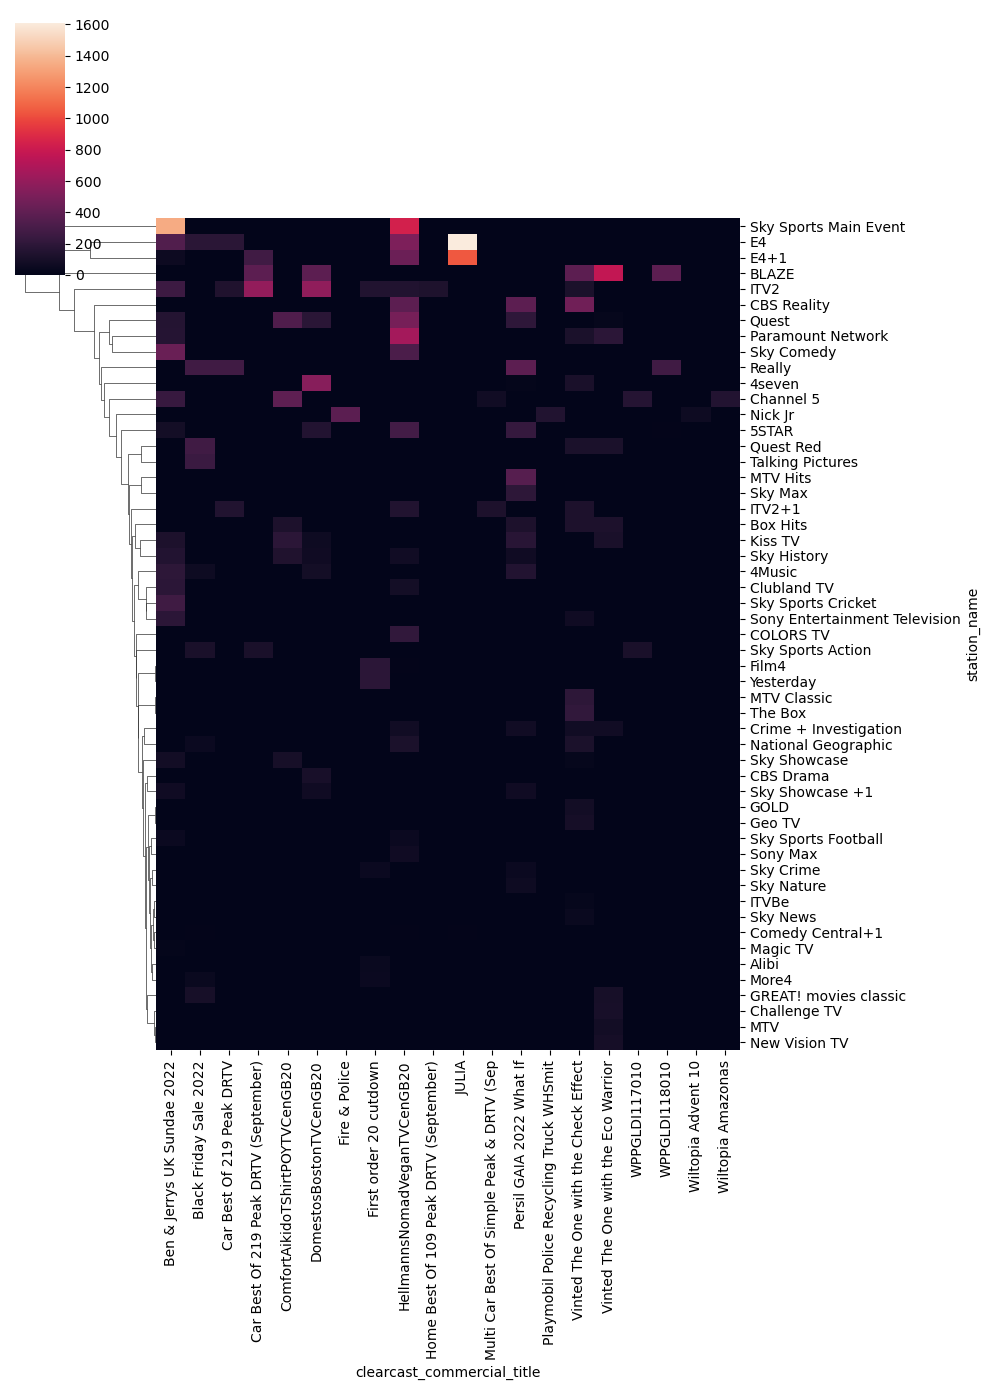

In [19]:
heatmap_data = spot_data[(spot_data["audience_name"]=='Adults 16-34') & (spot_data["panel_region"]=="BBC Network")].groupby(["clearcast_commercial_title", 
                                   "station_name" ])["audience_size_hundreds"].sum().round(1).unstack().fillna(0)
heatmap_data = heatmap_data.transpose()[heatmap_data.sum()>10] # Filter out small stations
_ = sns.clustermap(heatmap_data, figsize = (10,14), col_cluster=False)